In [1]:
import csv 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import math
import pytz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from statsmodels.api import OLS
from sklearn.metrics import r2_score, mean_squared_error

# Question 6

In [17]:
#Define function to extract features with different time scale
def readfile_HM(file_name):
    with open(file_name,encoding='utf8') as file:
        #Each line is a tweet info
        data=file.readlines()
    time_list=[]
    num_followers=[]
    num_retweets=[]
    num_replies=[]
    num_mentions=[]
    mentions_ratio=[]
    num_urls=[]
    urls_ratio=[]
    num_hashtags=[]
    hashtags_ratio=[]
    num_favorites=[]
    num_impressions=[]
    num_rank=[]
    author=[]
    for line in data:
        json_object=json.loads(line)
        time_list.append(json_object['citation_date'])#extract time a tweet is posted by
        num_followers.append(json_object['author']['followers'])#extract number of followers of teh person tweeting
        num_retweets.append(json_object['metrics']['citations']['total'])#extract number of retweets of a tweet
        num_replies.append(json_object['metrics']['citations']['replies'])#extract number of replies
        num_mentions.append(len(json_object['tweet']['entities']['user_mentions']))#extract number of mentions (length of the list)
        #mentions_ratio.append(len(json_object['tweet']['entities']['user_mentions'])/len(json_object['tweet']['text']))#extract ration of mentions
        num_urls.append(len(json_object['tweet']['entities']['urls']))#extract number of urls
        #urls_ratio.append(len(json_object['tweet']['entities']['urls'])/len(json_object['tweet']['text']))#extract ratio of urls
        num_hashtags.append(len(json_object['tweet']['entities']['hashtags']))#extract number of hastages
        #hashtags_ratio.append(len(json_object['tweet']['entities']['hashtags'])/len(json_object['tweet']['text']))#extract ratio of hastages
        num_favorites.append(json_object['tweet']['favorite_count'])
        num_impressions.append(json_object['metrics']['impressions'])
        num_rank.append(json_object['metrics']['ranking_score'])
        author.append(json_object['author']['name'])
    file.close()
    date_list=[]
    pst_tz=pytz.timezone('America/Los_Angeles')#time info conversion
    for time in time_list:
        date=datetime.datetime.fromtimestamp(time,pst_tz).replace(tzinfo=None)
        date_list.append(date)#save converted time into a new list
    date_df=pd.DataFrame(date_list,columns=['Date'])#generate a dataframe based on date
    date_df=date_df.set_index(date_df['Date'])#set a date string as index
    #print(date_df)
    date_df.drop(['Date'],'columns',inplace=True)#discard the second column
    date_df['num_tweets']=1 #initialize a new column and set the column name as num_tweets
    date_df['num_followers']=num_followers
    date_df['num_retweets']=num_retweets
    date_df['num_replies']=num_replies
    date_df['num_mentions']=num_mentions
    date_df['num_urls']=num_urls
    date_df['num_hashtags']=num_hashtags
    date_df['num_favorites']=num_favorites
    date_df['num_impressions']=num_impressions
    date_df['num_rank']=num_rank
    date_df['author']=author
    return date_df

def feature_extraction(date_df,time_period):
    feature_map=date_df.resample(time_period).sum()#total number of tweets, total num_followers, total num_retweets, replies, mentions, urls, hashtags
    #date_df['mentions_ratio']=mentions_ratio
    #date_df['urls_ratio']=urls_ratio
    #date_df['hashtags_ratio']=hashtags_ratio
    feature_map['max_followers']=date_df['num_followers'].resample(time_period).max()#pick maximum num of followers and resample
    feature_map['max_replies']=date_df['num_replies'].resample(time_period).max()
    feature_map['max_mentions']=date_df['num_mentions'].resample(time_period).max()
    feature_map['max_urls']=date_df['num_urls'].resample(time_period).max()
    feature_map['max_hashtags']=date_df['num_hashtags'].resample(time_period).max()
    #feature_map['mentions_ratio']=date_df['mentions_ratio'].resample('H').mean()
    #feature_map['urls_ratio']=date_df['urls_ratio'].resample('H').mean()
    #feature_map['hashtags_ratio']=date_df['hashtags_ratio'].resample('H').mean()
    feature_map['max_favorites']=date_df['num_favorites'].resample(time_period).max()
    feature_map['max_impressions']=date_df['num_impressions'].resample(time_period).max()
    feature_map['max_rank']=date_df['num_rank'].resample(time_period).max()
    feature_map['author']=date_df['author'].resample('H').apply(lambda x:len(x.unique()))
    feature_map['time']=feature_map.index.hour#extract hour index from 0 to 23
    return feature_map#return the entire feature map in dataframe format  

def divide_three(date_df):
    start_time='2015-02-01 08:00:00'
    end_time='2015-02-01 20:00:00'
    #the first part
    feature_map_first=feature_extraction(date_df,'H')
    feature_map_first=feature_map_first.iloc[feature_map_first.index<start_time,:]
    #the second part
    feature_map_second=feature_extraction(date_df,'5T')
    feature_map_second=feature_map_second.iloc[feature_map_second.index<=end_time,:]
    feature_map_second=feature_map_second.iloc[feature_map_second.index>=start_time,:]
    #the third part
    feature_map_third=feature_extraction(date_df,'H')
    feature_map_third=feature_map_third.iloc[feature_map_third.index>end_time,:]
    
    return feature_map_first, feature_map_second, feature_map_third

#implement OLS function and draw scatter plot
def ols_morefeatures(feature_map):
    #labels are the num_tweets in the next hour
    Y_train=feature_map['num_tweets'][1:]
    #Features are those five features in the previous hour, both labels and X_train data has length = samples-1
    X_train=feature_map.iloc[:-1]
    Y_train=np.nan_to_num(Y_train)#replace nan value into numeric value
    X_train=np.nan_to_num(X_train)
    model=OLS(Y_train,X_train)
    #model fitting
    results=model.fit()
    r2=r2_score(Y_train, results.fittedvalues)#get r2 score
    mse=mean_squared_error(Y_train,results.fittedvalues)#get mse score
    p_score=results.pvalues#get p_values
    index=np.argsort(p_score)#sort p_values from small to big
    sort_p_score=[]
    sort_feature_name=[]
    key_list=feature_map.keys()
    t_score=np.abs(results.tvalues)#get t_values and take absolute value
    index_t=np.flip(np.argsort(t_score))
    sort_t_score=[]
    sort_feature_name_t=[]
    for i in index:
        sort_p_score.append(p_score[i])
        sort_feature_name.append(key_list[i])
    for j in index_t:
        sort_t_score.append(t_score[j])
        sort_feature_name_t.append(key_list[j])
        
    #scatter plot
    for k in range(3):
        print('Feature is {}'.format(sort_feature_name[k]))
        plt.scatter(X_train[:,index[k]],results.fittedvalues)
        correction=np.linspace(0,np.max([X_train[:,index[k]],results.fittedvalues]),10)
        plt.plot(correction,correction,'r')
        plt.xlabel('Feature')
        plt.ylabel('Predictant')
        plt.show()
    return r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results
    

For gohawks file
Feature is num_tweets


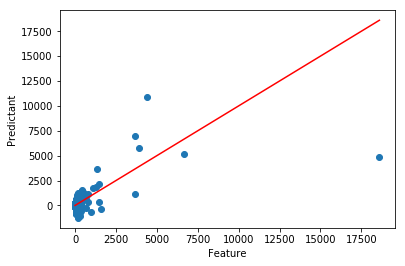

Feature is num_rank


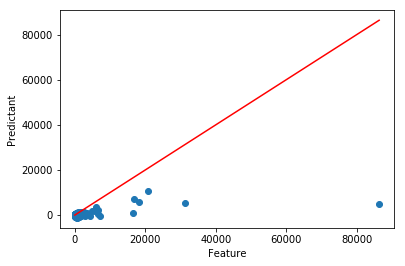

Feature is num_mentions


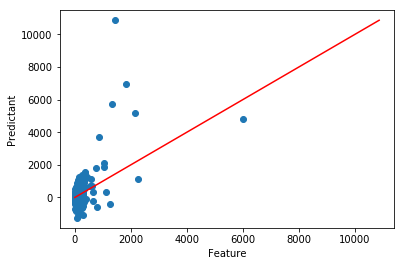

 before 08:00 am
The R-square score is
 0.7182812776899967

The mean_square_error is
 290429.5781567795

The sorted feature from the most important to the least important according to p value is
 ['num_tweets', 'num_rank', 'num_mentions', 'author', 'num_hashtags', 'num_replies', 'max_replies', 'max_hashtags', 'num_followers', 'num_urls', 'max_rank', 'max_followers', 'time', 'num_retweets', 'num_impressions', 'max_urls', 'num_favorites', 'max_favorites', 'max_mentions', 'max_impressions']

The sorted features p value is
 [3.278441359261802e-66, 8.256488388946015e-65, 9.884351100576811e-21, 5.7399690409599416e-18, 1.9752538234549302e-06, 6.223061691271866e-06, 0.0009171937720260397, 0.0011140608810956492, 0.00232354829101352, 0.007946238183926315, 0.08526775819604338, 0.11440004655816625, 0.1807653050197923, 0.498541178153617, 0.5351912146603567, 0.6117377426120356, 0.6669390130744446, 0.7183357337314218, 0.7916698467480523, 0.9219006814800571]

The sorted feature from the most important

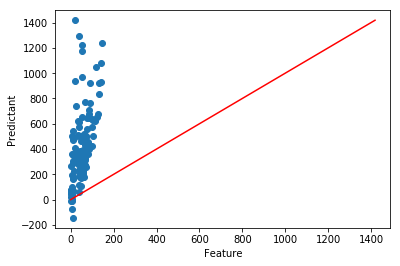

Feature is time


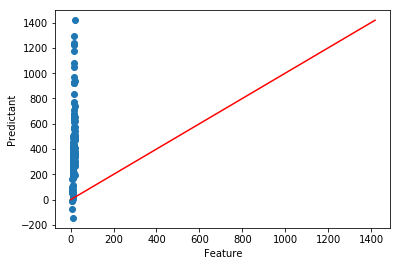

Feature is num_mentions


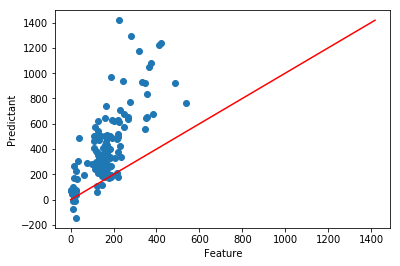

 after 08:00,before 20:00 am
The R-square score is
 0.5965301209546578

The mean_square_error is
 57215.012358173466

The sorted feature from the most important to the least important according to p value is
 ['num_urls', 'time', 'num_mentions', 'num_hashtags', 'num_tweets', 'num_rank', 'num_impressions', 'max_followers', 'max_rank', 'max_impressions', 'max_replies', 'num_followers', 'max_mentions', 'num_replies', 'max_urls', 'author', 'max_favorites', 'num_favorites', 'max_hashtags', 'num_retweets']

The sorted features p value is
 [0.021160221434447558, 0.03183768070174083, 0.044104479892802, 0.0634427800219468, 0.08824185662015208, 0.09634961171867265, 0.28644714390284054, 0.2932439203660505, 0.3519740080737783, 0.3799894366879829, 0.3945659128039245, 0.45230961822886484, 0.4980751462755303, 0.5298229529035683, 0.6933137207519112, 0.7510065297631356, 0.7877719481256622, 0.8005789835311412, 0.8664265111235414, 0.9142591490020062]

The sorted feature from the most important to the lea

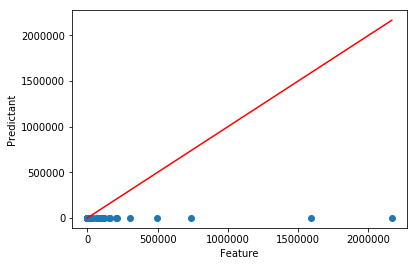

Feature is max_followers


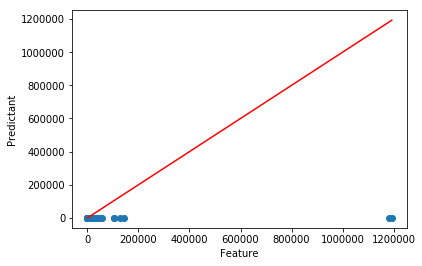

Feature is num_impressions


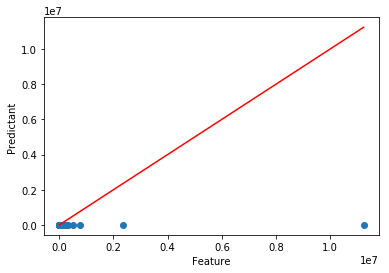

 after 20:00 am
The R-square score is
 0.9903877818311541

The mean_square_error is
 85.55345645729177

The sorted feature from the most important to the least important according to p value is
 ['num_followers', 'max_followers', 'num_impressions', 'max_impressions', 'num_rank', 'num_tweets', 'num_replies', 'max_replies', 'author', 'num_retweets', 'max_favorites', 'num_favorites', 'num_hashtags', 'num_urls', 'time', 'max_rank', 'max_mentions', 'max_hashtags', 'max_urls', 'num_mentions']

The sorted features p value is
 [7.816819265331116e-35, 2.034071078981049e-31, 2.482944760916856e-31, 3.303687510620601e-31, 9.671450262338416e-17, 3.830423097232718e-12, 1.540585689234655e-11, 8.570471288133035e-09, 8.81509934564699e-07, 1.4275656169620534e-05, 0.000678939292771636, 0.000761860376544712, 0.0009495659567571701, 0.01620573413959146, 0.13131651705563724, 0.15505622871581823, 0.21966334839575777, 0.5642040911956501, 0.9007399792617916, 0.964707945521168]

The sorted feature from the most 

In [18]:
#gohawks
#extract feature map
print('For gohawks file')
date_df=readfile_HM('tweets_#gohawks.txt')
feature_map_first,feature_map_second,feature_map_third=divide_three(date_df)
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_first)
print(' before 08:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_second)
print(' after 08:00,before 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_third)
print(' after 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

For gopatriots file
Feature is author


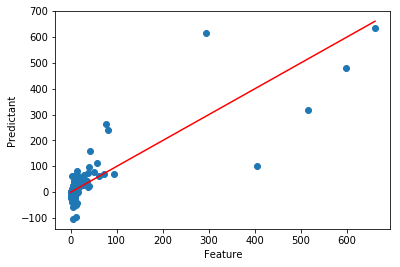

Feature is num_mentions


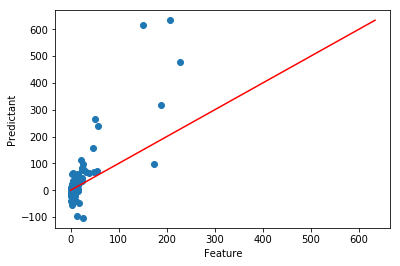

Feature is num_replies


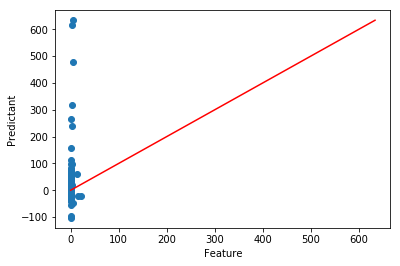

 before 08:00 am
The R-square score is
 0.7755494174521449

The mean_square_error is
 920.3685592825796

The sorted feature from the most important to the least important according to p value is
 ['author', 'num_mentions', 'num_replies', 'max_replies', 'num_tweets', 'num_rank', 'max_impressions', 'num_impressions', 'max_followers', 'max_mentions', 'num_followers', 'num_hashtags', 'max_rank', 'max_favorites', 'num_retweets', 'max_hashtags', 'num_favorites', 'max_urls', 'num_urls', 'time']

The sorted features p value is
 [5.378933787081102e-18, 2.254966175400327e-16, 1.575101527637908e-08, 1.8375602156999665e-08, 3.372341355651492e-05, 7.635204532912339e-05, 7.740470193036627e-05, 0.00018526288493865117, 0.0011310007092843845, 0.0011564597455092957, 0.0025351353005591093, 0.02203827213863584, 0.10462526846293667, 0.13319146459967846, 0.2087534095199517, 0.34623491802815787, 0.4126793800783112, 0.45148458476863973, 0.7877162688389627, 0.8711862914179125]

The sorted feature from the most

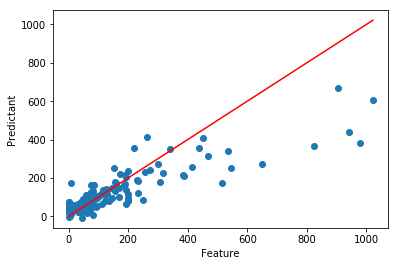

Feature is max_followers


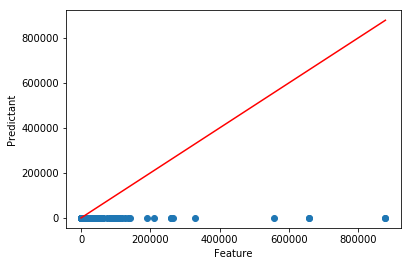

Feature is max_impressions


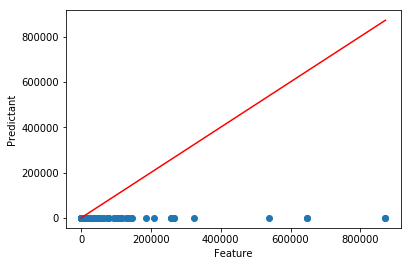

 after 08:00,before 20:00 am
The R-square score is
 0.5532481788451284

The mean_square_error is
 11431.882626261791

The sorted feature from the most important to the least important according to p value is
 ['num_retweets', 'max_followers', 'max_impressions', 'num_mentions', 'time', 'num_followers', 'max_replies', 'num_replies', 'max_urls', 'num_impressions', 'max_mentions', 'max_rank', 'num_rank', 'num_hashtags', 'num_urls', 'max_hashtags', 'num_tweets', 'max_favorites', 'num_favorites', 'author']

The sorted features p value is
 [2.2001986797261307e-05, 0.0003186096745422514, 0.0003560364281377788, 0.006329682828366009, 0.014960408393669085, 0.07999907020981151, 0.12608708581824507, 0.14675552374155998, 0.16574904759482142, 0.1759705496749083, 0.2044755414306868, 0.42123817191083857, 0.4328473235720516, 0.5105766641044174, 0.678970299940318, 0.7793010842479567, 0.8521914692353924, 0.8642788851521233, 0.9575899083818331, 0.9757598649389339]

The sorted feature from the most importan

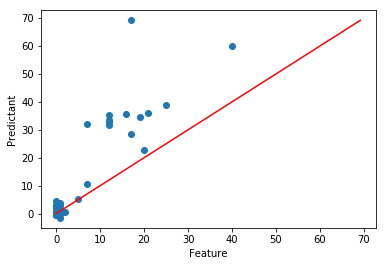

Feature is author


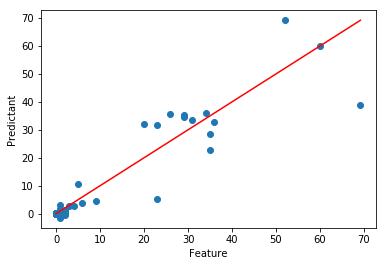

Feature is max_mentions


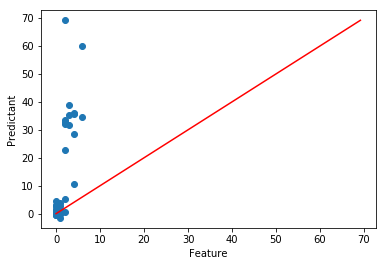

 after 20:00 am
The R-square score is
 0.9961870472463135

The mean_square_error is
 0.5728961512413965

The sorted feature from the most important to the least important according to p value is
 ['num_mentions', 'author', 'max_mentions', 'num_rank', 'num_impressions', 'max_impressions', 'num_followers', 'num_retweets', 'max_followers', 'num_hashtags', 'num_urls', 'max_favorites', 'time', 'max_urls', 'num_favorites', 'num_tweets', 'max_rank', 'num_replies', 'max_replies', 'max_hashtags']

The sorted features p value is
 [5.765395806399943e-23, 6.268833926867147e-15, 1.7588650931277267e-11, 3.1911191955084917e-10, 1.7188061110966635e-09, 5.022942880831507e-09, 4.2061800331330866e-08, 2.6413593166779786e-07, 1.0225187532389824e-06, 0.0001951930369895624, 0.001656851112045208, 0.01729078311114018, 0.02116000745548916, 0.03718284091823333, 0.1522915098876623, 0.23677885764413706, 0.48677980646708785, 0.494832583604365, 0.610212782361703, 0.9864505498393262]

The sorted feature from the mos

In [19]:
#gopatriots
#extract feature map
print('For gopatriots file')
date_df=readfile_HM('tweets_#gopatriots.txt')
feature_map_first,feature_map_second,feature_map_third=divide_three(date_df)
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_first)
print(' before 08:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_second)
print(' after 08:00,before 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_third)
print(' after 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

For nfl file
Feature is num_replies


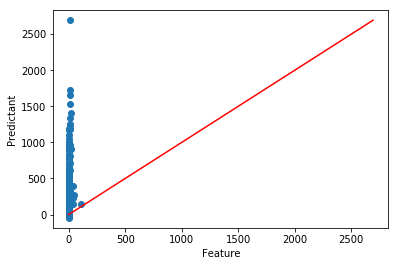

Feature is max_replies


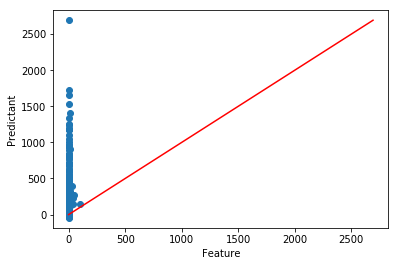

Feature is max_impressions


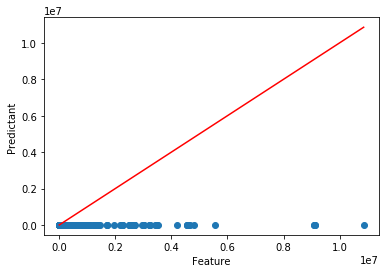

 before 08:00 am
The R-square score is
 0.5761932256012436

The mean_square_error is
 57212.856123132

The sorted feature from the most important to the least important according to p value is
 ['num_replies', 'max_replies', 'max_impressions', 'num_urls', 'num_impressions', 'max_followers', 'author', 'num_followers', 'num_tweets', 'max_hashtags', 'num_rank', 'num_hashtags', 'time', 'max_mentions', 'num_favorites', 'num_retweets', 'max_urls', 'max_favorites', 'num_mentions', 'max_rank']

The sorted features p value is
 [8.913289170589225e-08, 1.6097228807280225e-07, 0.006087819881549484, 0.007957021459463292, 0.010687101880783858, 0.015560784858941943, 0.017325532722809622, 0.03616882916956054, 0.03885363499638544, 0.0893678133386832, 0.10181911193368846, 0.15990496648505204, 0.28717762269135194, 0.35363449237654887, 0.5152400244262783, 0.6785462300202102, 0.6923686634071866, 0.6995637292050381, 0.7136204190878392, 0.8337984467277113]

The sorted feature from the most important to the l

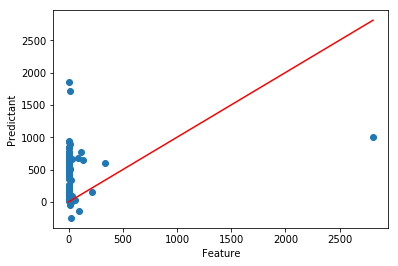

Feature is num_favorites


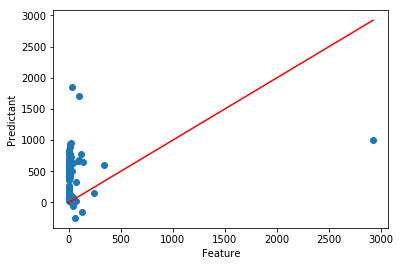

Feature is max_followers


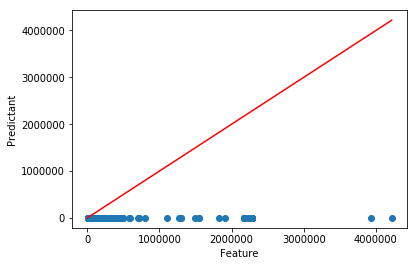

 after 08:00,before 20:00 am
The R-square score is
 0.8781009475703854

The mean_square_error is
 14059.79903115984

The sorted feature from the most important to the least important according to p value is
 ['max_favorites', 'num_favorites', 'max_followers', 'max_impressions', 'max_hashtags', 'num_rank', 'author', 'num_impressions', 'num_followers', 'time', 'num_tweets', 'num_hashtags', 'max_rank', 'max_urls', 'num_replies', 'num_urls', 'max_mentions', 'num_mentions', 'num_retweets', 'max_replies']

The sorted features p value is
 [3.2307183858304137e-06, 3.7742181573607275e-06, 0.043321244240147105, 0.04468612563961547, 0.054858490855878225, 0.06037623223397863, 0.11260617843675579, 0.13028795169644966, 0.16498937254633156, 0.16555568713872063, 0.24950714886661224, 0.2647695945571294, 0.32407659597296923, 0.40419591786512876, 0.5367343971321501, 0.6997839697558647, 0.8572602135972082, 0.8773780028787042, 0.893172127082289, 0.9332500595570448]

The sorted feature from the most importa

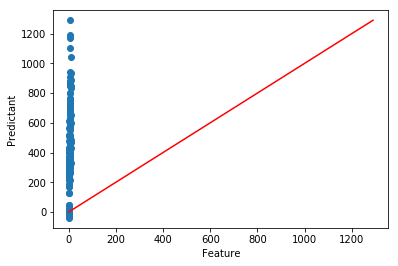

Feature is time


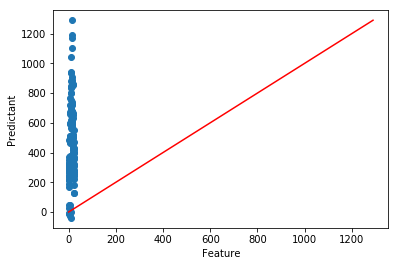

Feature is author


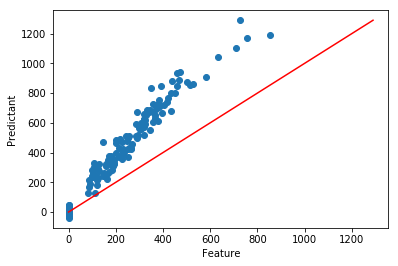

 after 20:00 am
The R-square score is
 0.8486801597656115

The mean_square_error is
 13004.306811146816

The sorted feature from the most important to the least important according to p value is
 ['max_mentions', 'time', 'author', 'max_hashtags', 'num_followers', 'num_impressions', 'max_followers', 'max_impressions', 'num_favorites', 'max_favorites', 'num_rank', 'num_hashtags', 'num_replies', 'max_urls', 'max_replies', 'num_urls', 'num_tweets', 'num_retweets', 'max_rank', 'num_mentions']

The sorted features p value is
 [0.013470953522093957, 0.01992727629857788, 0.045053925081495264, 0.19811113332670816, 0.22503391572341466, 0.2555433969515939, 0.25725320484322617, 0.30294705635013985, 0.32679035437160087, 0.35925516809473046, 0.45309312309866456, 0.4727102129072225, 0.5686899797101199, 0.5809729541776736, 0.8290733482861784, 0.8595421899368934, 0.8765456701680097, 0.8851559177053989, 0.9699819076740837, 0.9901615514874285]

The sorted feature from the most important to the least impo

In [20]:
#nfl
#extract feature map
print('For nfl file')
date_df=readfile_HM('tweets_#nfl.txt')
feature_map_first,feature_map_second,feature_map_third=divide_three(date_df)
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_first)
print(' before 08:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_second)
print(' after 08:00,before 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_third)
print(' after 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

For patriots file
Feature is num_followers


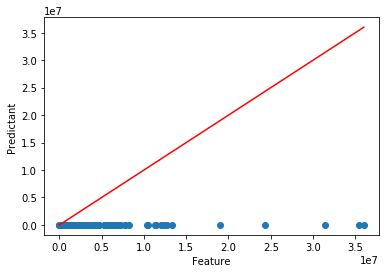

Feature is max_followers


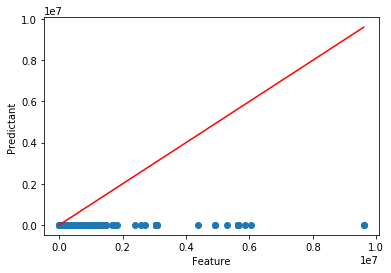

Feature is num_impressions


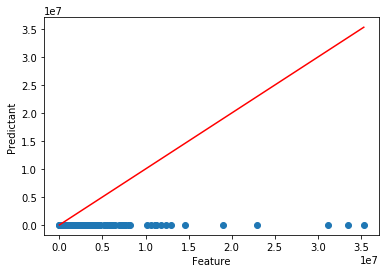

 before 08:00 am
The R-square score is
 0.6528935149560843

The mean_square_error is
 271189.99004075147

The sorted feature from the most important to the least important according to p value is
 ['num_followers', 'max_followers', 'num_impressions', 'max_impressions', 'num_rank', 'num_tweets', 'max_mentions', 'num_replies', 'max_replies', 'num_mentions', 'author', 'num_urls', 'max_hashtags', 'num_favorites', 'num_hashtags', 'max_rank', 'max_favorites', 'time', 'num_retweets', 'max_urls']

The sorted features p value is
 [2.0373496560502525e-11, 7.895739349060031e-11, 1.159006611148679e-08, 9.949752599753763e-08, 2.540316607246793e-05, 0.00015287558231663216, 0.0003995106167493074, 0.015169034784562394, 0.015422465582704468, 0.030115007829083527, 0.07465736007341495, 0.08568723581915366, 0.13580018874244382, 0.14442824496228523, 0.15829547121562487, 0.2060060703531967, 0.5704029876425154, 0.7539943659477086, 0.765140109055187, 0.7907252205732997]

The sorted feature from the most impor

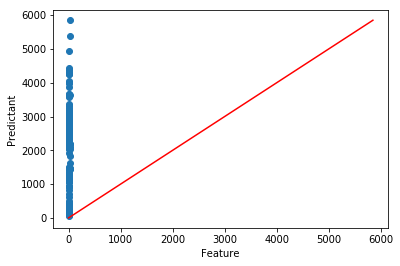

Feature is num_hashtags


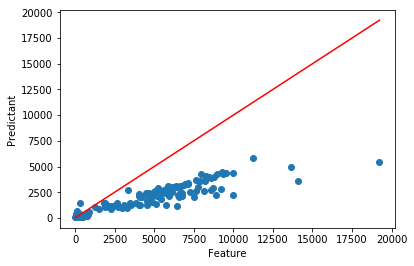

Feature is num_replies


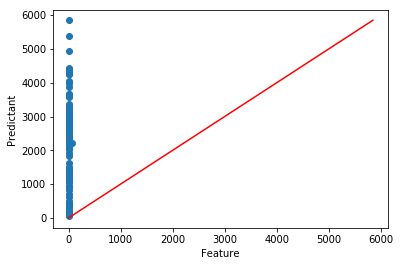

 after 08:00,before 20:00 am
The R-square score is
 0.7515258260717205

The mean_square_error is
 577538.7729797943

The sorted feature from the most important to the least important according to p value is
 ['time', 'num_hashtags', 'num_replies', 'num_favorites', 'author', 'max_replies', 'max_rank', 'max_favorites', 'num_urls', 'num_mentions', 'max_followers', 'max_impressions', 'num_followers', 'max_hashtags', 'max_mentions', 'max_urls', 'num_impressions', 'num_rank', 'num_tweets', 'num_retweets']

The sorted features p value is
 [0.006128675876471685, 0.0547918128154343, 0.07047338857065386, 0.07977445340510979, 0.08192209303498664, 0.09757249628884823, 0.11359629722353459, 0.12522648294938624, 0.24771034038573111, 0.31390720278459333, 0.5562756444239194, 0.5909743469041654, 0.7185242917546346, 0.7399010589741113, 0.7399644412768118, 0.7463006704522814, 0.7718455877513549, 0.8357365962854578, 0.8364284368928943, 0.9337217302416205]

The sorted feature from the most important to the 

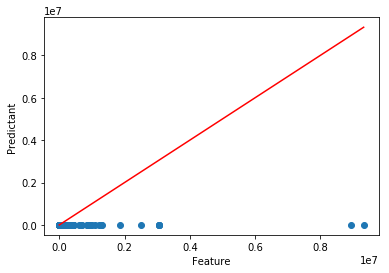

Feature is max_followers


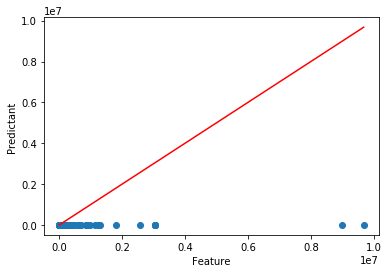

Feature is max_replies


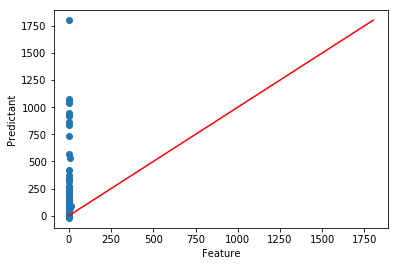

 after 20:00 am
The R-square score is
 0.9544466811383617

The mean_square_error is
 3628.906837544456

The sorted feature from the most important to the least important according to p value is
 ['max_impressions', 'max_followers', 'max_replies', 'num_replies', 'num_retweets', 'num_impressions', 'num_followers', 'time', 'num_favorites', 'max_mentions', 'num_mentions', 'author', 'num_urls', 'max_rank', 'num_rank', 'max_favorites', 'max_urls', 'max_hashtags', 'num_hashtags', 'num_tweets']

The sorted features p value is
 [2.02085868930866e-09, 4.8914201758312835e-09, 4.335654690674526e-08, 2.5630024067353694e-07, 0.0015640321006972463, 0.0034317778530189315, 0.010618903017280155, 0.011702591760330013, 0.015258027271557666, 0.021002313206090983, 0.040184283124247884, 0.3686729970298619, 0.4945179438633057, 0.5900590357243085, 0.658078460881182, 0.7207272659493871, 0.725731534322485, 0.7364326364580184, 0.8665883312426561, 0.9849736858877043]

The sorted feature from the most important to 

In [21]:
#patriots
#extract feature map
print('For patriots file')
date_df=readfile_HM('tweets_#patriots.txt')
feature_map_first,feature_map_second,feature_map_third=divide_three(date_df)
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_first)
print(' before 08:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_second)
print(' after 08:00,before 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_third)
print(' after 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

For sb49 file
Feature is num_urls


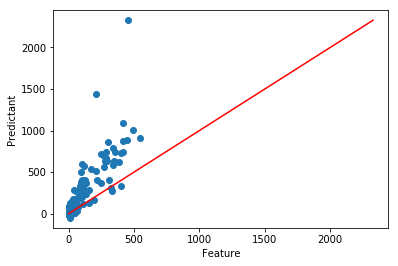

Feature is num_rank


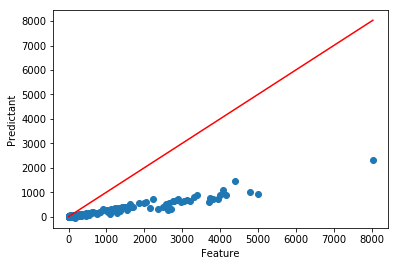

Feature is num_hashtags


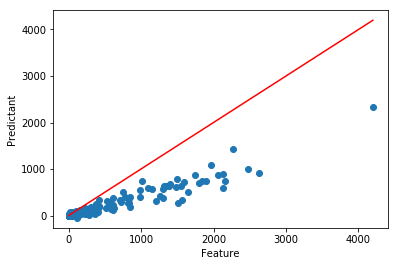

 before 08:00 am
The R-square score is
 0.9129792529101078

The mean_square_error is
 4538.58957604733

The sorted feature from the most important to the least important according to p value is
 ['num_urls', 'num_rank', 'num_hashtags', 'max_impressions', 'max_replies', 'author', 'num_impressions', 'max_followers', 'max_favorites', 'num_followers', 'num_favorites', 'max_mentions', 'num_tweets', 'num_retweets', 'time', 'max_urls', 'num_replies', 'max_hashtags', 'max_rank', 'num_mentions']

The sorted features p value is
 [8.620796564927166e-08, 7.566693883077461e-06, 8.484043718902542e-06, 1.4489859139788498e-05, 7.579362310033162e-05, 0.00015311453738549083, 0.0001868128451140996, 0.0008963692532214776, 0.004760391746258356, 0.01425282578009731, 0.015325662230584985, 0.021643718391786398, 0.06357435598275694, 0.14249273649298805, 0.24477263652947234, 0.24697264731380472, 0.2711039117499056, 0.5841099006972481, 0.6145801944927434, 0.7996504977152437]

The sorted feature from the most imp

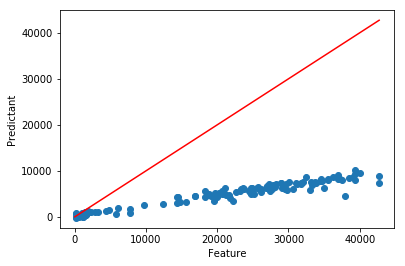

Feature is num_tweets


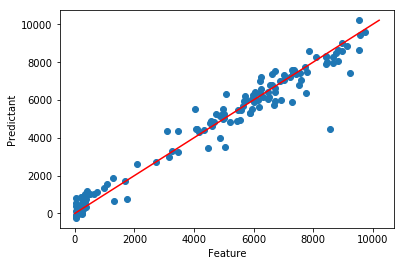

Feature is max_mentions


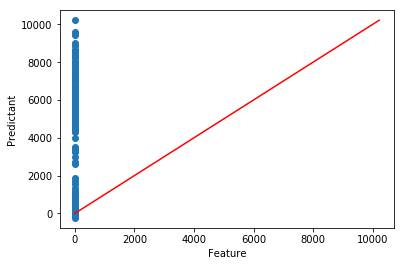

 after 08:00,before 20:00 am
The R-square score is
 0.8992089015845203

The mean_square_error is
 974502.9848165425

The sorted feature from the most important to the least important according to p value is
 ['num_rank', 'num_tweets', 'max_mentions', 'time', 'max_rank', 'num_mentions', 'num_urls', 'num_impressions', 'num_followers', 'max_followers', 'max_replies', 'max_impressions', 'max_hashtags', 'num_replies', 'num_retweets', 'num_favorites', 'max_urls', 'author', 'max_favorites', 'num_hashtags']

The sorted features p value is
 [0.0026149817231257413, 0.007236501513939502, 0.007560950934942801, 0.05252574350293697, 0.10658297184706413, 0.1739833710592173, 0.19637430735900938, 0.262494845887284, 0.26977106699651776, 0.3052001653817386, 0.30643390447728575, 0.32794736169700134, 0.5566371438527147, 0.634675141048574, 0.6936764853282351, 0.7772015921539872, 0.795848792256182, 0.8324915761511752, 0.9080936125949546, 0.9479323416610885]

The sorted feature from the most important to the 

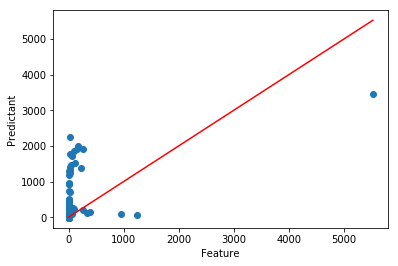

Feature is num_rank


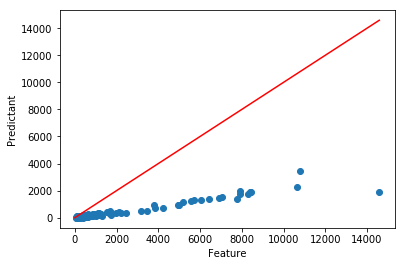

Feature is num_tweets


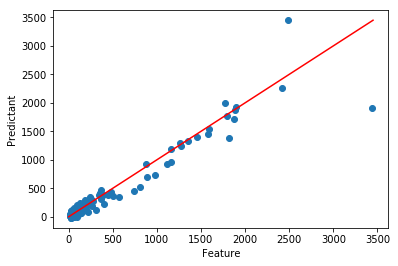

 after 20:00 am
The R-square score is
 0.9725413200970411

The mean_square_error is
 9207.513277912749

The sorted feature from the most important to the least important according to p value is
 ['num_favorites', 'num_rank', 'num_tweets', 'max_favorites', 'num_mentions', 'max_urls', 'time', 'max_mentions', 'author', 'num_retweets', 'num_hashtags', 'num_impressions', 'max_rank', 'num_followers', 'max_hashtags', 'num_replies', 'max_impressions', 'max_replies', 'num_urls', 'max_followers']

The sorted features p value is
 [3.4535388987105656e-10, 9.388140965002095e-07, 2.204750865671111e-05, 0.0002576959855026999, 0.00044480055548232737, 0.018165880387846764, 0.0775675324902469, 0.10124830121652766, 0.21276654229592354, 0.3628228696617929, 0.3737436298733239, 0.3928184338848594, 0.4765145896989498, 0.553183814380073, 0.5717431967870585, 0.739557868655967, 0.7705744729095354, 0.8621198486956944, 0.9245155411248156, 0.9959859099141095]

The sorted feature from the most important to the leas

In [22]:
#sb49
#extract feature map
print('For sb49 file')
date_df=readfile_HM('tweets_#sb49.txt')
feature_map_first,feature_map_second,feature_map_third=divide_three(date_df)
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_first)
print(' before 08:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_second)
print(' after 08:00,before 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_third)
print(' after 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

For superbowl file
Feature is num_replies


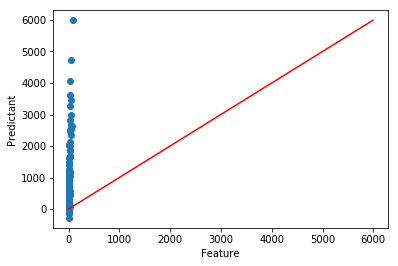

Feature is max_replies


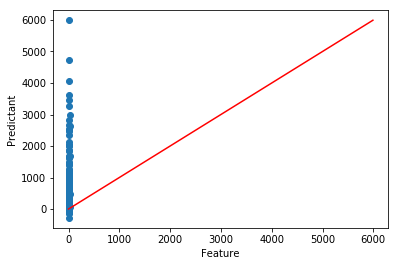

Feature is num_mentions


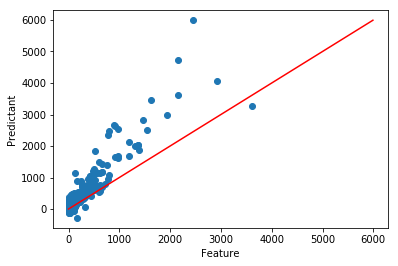

 before 08:00 am
The R-square score is
 0.498352507688684

The mean_square_error is
 432883.86580593657

The sorted feature from the most important to the least important according to p value is
 ['num_replies', 'max_replies', 'num_mentions', 'max_hashtags', 'num_retweets', 'num_tweets', 'num_rank', 'num_urls', 'max_mentions', 'max_rank', 'max_followers', 'num_hashtags', 'num_favorites', 'max_favorites', 'time', 'max_impressions', 'num_followers', 'num_impressions', 'max_urls']

The sorted features p value is
 [3.8047855076908965e-09, 5.088022146283544e-05, 0.0006163896787430518, 0.03245095155879134, 0.06235462556585816, 0.07184176727929291, 0.1016113775494433, 0.10783566926182873, 0.19062820926163723, 0.19326966945524784, 0.22623535024338384, 0.23194153538777112, 0.2510838674430486, 0.2572613134521202, 0.26668259606348643, 0.31096714398953995, 0.38262895522901763, 0.4688393924253994, 0.7918063858288941]

The sorted feature from the most important to the least important according to t 

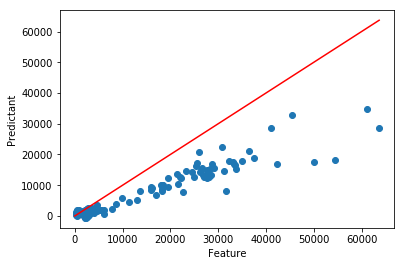

Feature is time


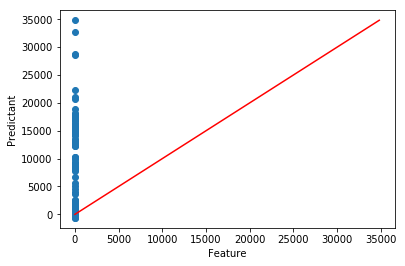

Feature is num_urls


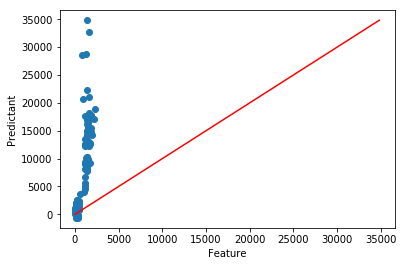

 after 08:00,before 20:00 am
The R-square score is
 0.9418698078281975

The mean_square_error is
 3620425.3173149717

The sorted feature from the most important to the least important according to p value is
 ['num_hashtags', 'time', 'num_urls', 'num_rank', 'num_mentions', 'max_mentions', 'max_rank', 'num_favorites', 'max_favorites', 'max_replies', 'max_hashtags', 'num_replies', 'max_urls', 'num_tweets', 'max_impressions', 'max_followers', 'num_followers', 'num_impressions', 'num_retweets']

The sorted features p value is
 [1.2984417908042014e-06, 0.0012886678508166151, 0.004753135843401084, 0.008370713863284848, 0.008945506376707189, 0.01827874561919111, 0.06111818459893336, 0.0695261362229981, 0.07934648028995524, 0.0981524114052876, 0.12053279928524777, 0.14659334575598112, 0.3125354728590909, 0.3632608209863374, 0.3879161554072993, 0.3915778413560387, 0.40905525674999055, 0.4147513138354816, 0.44296374281069895]

The sorted feature from the most important to the least important acc

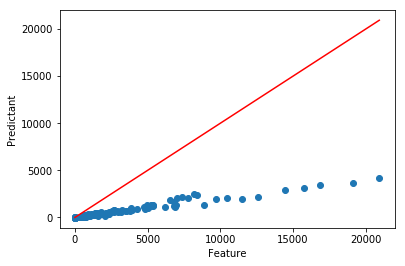

Feature is num_tweets


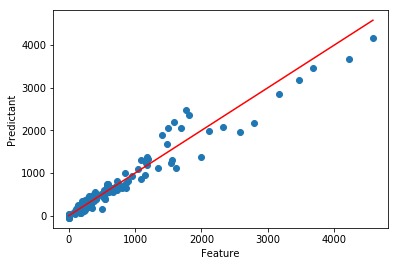

Feature is num_favorites


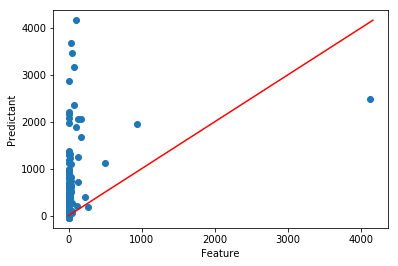

 after 20:00 am
The R-square score is
 0.9041839210398852

The mean_square_error is
 67823.87729597026

The sorted feature from the most important to the least important according to p value is
 ['num_rank', 'num_tweets', 'num_favorites', 'num_urls', 'num_hashtags', 'max_favorites', 'time', 'num_mentions', 'max_hashtags', 'max_mentions', 'max_urls', 'max_rank', 'max_followers', 'num_replies', 'num_retweets', 'max_replies', 'num_followers', 'max_impressions', 'num_impressions']

The sorted features p value is
 [6.315946453044363e-05, 0.00011288881871610426, 0.038089181321323225, 0.04176697714910772, 0.04258110113918272, 0.06182495338792568, 0.3428939457656728, 0.367827807910591, 0.4206797728568301, 0.5389123787769439, 0.6194764203550929, 0.7591871872556161, 0.7664505592018651, 0.7843213404961447, 0.8195695407033606, 0.8226250327004084, 0.8863778064107808, 0.9564666052225386, 0.9665107999973506]

The sorted feature from the most important to the least important according to t value is
 [

In [11]:
#superbowl
#extract feature map
print('For superbowl file')
date_df=readfile_HM('tweets_#superbowl.txt')
feature_map_first,feature_map_second,feature_map_third=divide_three(date_df)
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_first)
print(' before 08:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_second)
print(' after 08:00,before 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_third)
print(' after 20:00 am')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

# Question 7

In [24]:
#def function to read and combine data together
def readfile_aggregate(file_list):
    time_list=[]
    num_followers=[]
    num_retweets=[]
    num_replies=[]
    num_mentions=[]
    mentions_ratio=[]
    num_urls=[]
    urls_ratio=[]
    num_hashtags=[]
    hashtags_ratio=[]
    num_favorites=[]
    num_impressions=[]
    num_rank=[]
    for file_name in file_list:
        
        with open(file_name,encoding='utf8') as file:
        #Each line is a tweet info
            data=file.readlines()

        for line in data:
            json_object=json.loads(line)
            time_list.append(json_object['citation_date'])#extract time a tweet is posted by
            num_followers.append(json_object['author']['followers'])#extract number of followers of teh person tweeting
            num_retweets.append(json_object['metrics']['citations']['total'])#extract number of retweets of a tweet
            num_replies.append(json_object['metrics']['citations']['replies'])#extract number of replies
            num_mentions.append(len(json_object['tweet']['entities']['user_mentions']))#extract number of mentions (length of the list)
            mentions_ratio.append(len(json_object['tweet']['entities']['user_mentions'])/len(json_object['tweet']['text']))#extract ration of mentions
            num_urls.append(len(json_object['tweet']['entities']['urls']))#extract number of urls
            urls_ratio.append(len(json_object['tweet']['entities']['urls'])/len(json_object['tweet']['text']))#extract ratio of urls
            num_hashtags.append(len(json_object['tweet']['entities']['hashtags']))#extract number of hastages
            hashtags_ratio.append(len(json_object['tweet']['entities']['hashtags'])/len(json_object['tweet']['text']))#extract ratio of hastages
            num_favorites.append(json_object['tweet']['favorite_count'])
            num_impressions.append(json_object['metrics']['impressions'])
            num_rank.append(json_object['metrics']['ranking_score'])
            author.append(json_object['author']['name'])
        file.close()
    date_list=[]
    pst_tz=pytz.timezone('America/Los_Angeles')#time info conversion
    for time in time_list:
        date=datetime.datetime.fromtimestamp(time,pst_tz).replace(tzinfo=None)
        date_list.append(date)#save converted time into a new list
    date_df=pd.DataFrame(date_list,columns=['Date'])#generate a dataframe based on date
    date_df=date_df.set_index(date_df['Date'])#set a date string as index
    #print(date_df)
    date_df.drop(['Date'],'columns',inplace=True)#discard the second column
    date_df['num_tweets']=1 #initialize a new column and set the column name as num_tweets
    date_df['num_followers']=num_followers
    date_df['num_retweets']=num_retweets
    date_df['num_replies']=num_replies
    date_df['num_mentions']=num_mentions
    date_df['num_urls']=num_urls
    date_df['num_hashtags']=num_hashtags
    date_df['num_favorites']=num_favorites
    date_df['num_impressions']=num_impressions
    date_df['num_rank']=num_rank
    date_df['author']=author
    
    return date_df



In [13]:
file_list=['tweets_#gohawks.txt','tweets_#gopatriots.txt','tweets_#nfl.txt','tweets_#patriots.txt','tweets_#sb49.txt','tweets_#superbowl.txt']
date_df_agg=readfile_aggregate(file_list)
feature_map_all_first,feature_map_all_second,feature_map_all_third=divide_three(date_df_agg)

Feature is num_replies


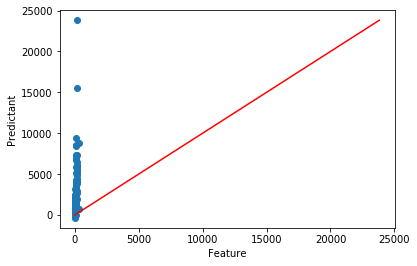

Feature is max_replies


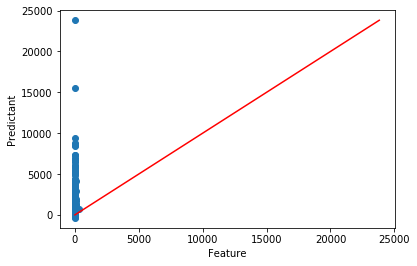

Feature is num_rank


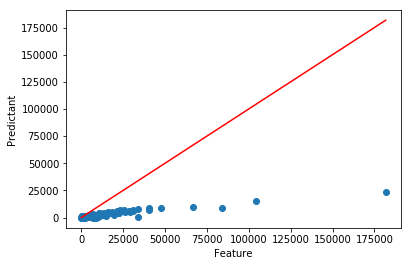

For all files trials---First segment
The R-square score is
 0.46447001628713946

The mean_square_error is
 4015721.7823774465

The sorted feature from the most important to the least important according to p value is
 ['num_replies', 'max_replies', 'num_rank', 'num_tweets', 'max_mentions', 'max_hashtags', 'num_retweets', 'num_mentions', 'max_urls', 'max_favorites', 'num_hashtags', 'num_urls', 'time', 'max_rank', 'num_favorites', 'num_followers', 'max_impressions', 'num_impressions', 'max_followers']

The sorted features p value is
 [4.0241497285876767e-05, 0.0003838102658006803, 0.0029665651788778574, 0.00860281885302205, 0.09741678645443502, 0.10101148329692582, 0.11830896804663983, 0.19119956466931243, 0.24057828752154653, 0.32601664262130914, 0.3915671674394574, 0.3949196348176722, 0.5047198237388097, 0.6084528991709168, 0.6709230206419305, 0.7884294604955431, 0.8192482898680494, 0.860362035189775, 0.9329160747723444]

The sorted feature from the most important to the least importan

In [14]:
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_all_first)
print('For all files trials---First segment')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

Feature is time


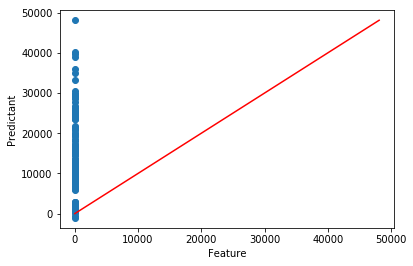

Feature is max_rank


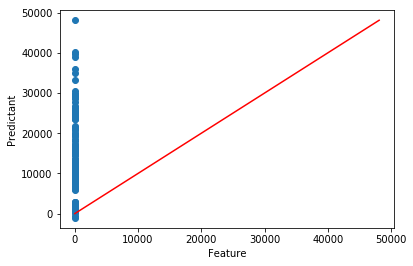

Feature is num_hashtags


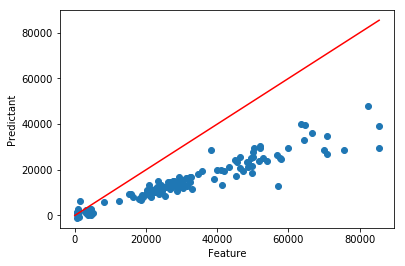

For all files trials---First segment
The R-square score is
 0.8940237813357184

The mean_square_error is
 12112484.100450732

The sorted feature from the most important to the least important according to p value is
 ['time', 'max_rank', 'num_hashtags', 'max_mentions', 'num_replies', 'num_rank', 'max_replies', 'num_favorites', 'num_mentions', 'max_urls', 'num_tweets', 'max_favorites', 'max_hashtags', 'num_retweets', 'num_impressions', 'num_urls', 'num_followers', 'max_followers', 'max_impressions']

The sorted features p value is
 [2.6468075494866626e-05, 0.001391067137235304, 0.0014560082852804657, 0.00839855219390053, 0.07839408587487398, 0.1272768017820694, 0.16071019206450413, 0.16799122398612285, 0.23465607105373262, 0.28871206607746697, 0.42111278351927117, 0.4880122594020253, 0.5077761353500605, 0.6499504653153299, 0.9039589112548162, 0.9298459749724772, 0.9390593031302851, 0.9617818761291101, 0.9802465770284658]

The sorted feature from the most important to the least important

In [15]:
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_all_second)
print('For all files trials---First segment')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

Feature is num_rank


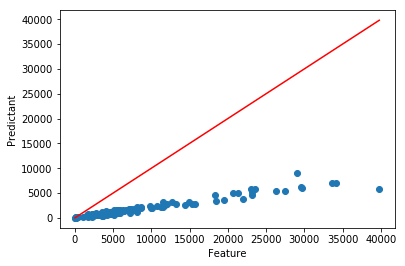

Feature is num_tweets


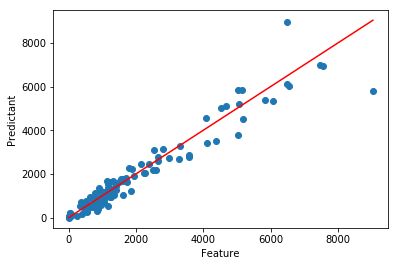

Feature is num_favorites


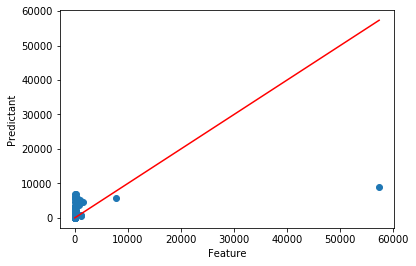

For all files trials---First segment
The R-square score is
 0.9600006089590952

The mean_square_error is
 122806.84418054532

The sorted feature from the most important to the least important according to p value is
 ['num_rank', 'num_tweets', 'num_favorites', 'max_favorites', 'max_replies', 'time', 'num_hashtags', 'num_urls', 'num_replies', 'max_mentions', 'num_impressions', 'max_urls', 'max_impressions', 'num_mentions', 'max_rank', 'num_followers', 'max_hashtags', 'max_followers', 'num_retweets']

The sorted features p value is
 [2.1443560571051358e-08, 2.28497204703214e-07, 0.0002370109751762841, 0.0004946268150291868, 0.001793189083055238, 0.0036452686554468566, 0.006647653621627022, 0.010164077528041774, 0.024871290631097765, 0.06710979660249068, 0.17943346970015256, 0.20049508726838994, 0.21577110570671695, 0.5259547155950925, 0.5281339304564812, 0.5381894745576805, 0.7489069066981018, 0.9489821945595672, 0.9992945132670803]

The sorted feature from the most important to the leas

In [16]:
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map_all_third)
print('For all files trials---First segment')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))